### 2. Signal Preprocessing and Noise Removal

## Imports:

In [1]:
import wfdb
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt
from scipy.signal import butter



## Read the data

In [2]:
data_path = '../data'
record_name = '100'
record = wfdb.rdrecord(os.path.join(data_path, record_name))
fs = record.fs
channel = 'MLII'
ch_idx = record.sig_name.index(channel)
signal = record.p_signal[:, ch_idx]

### 1. Baseline Wander Removal (High-pass via Fourier Transform)

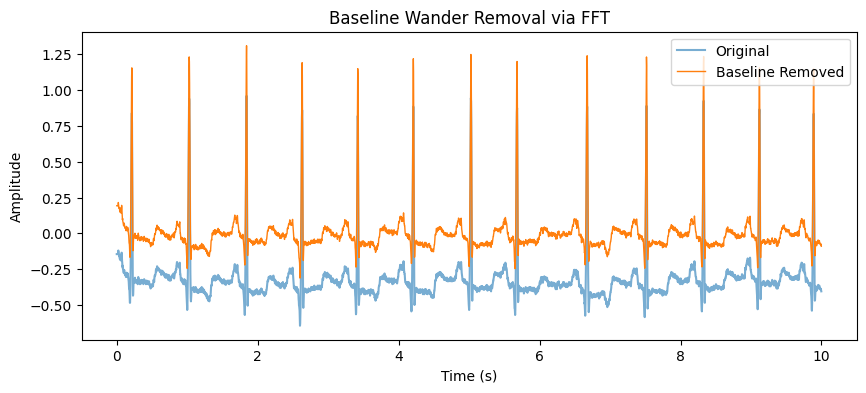

In [8]:
# Fourier Transform
freqs = np.fft.rfftfreq(len(signal), d=1/fs)
fft_signal = np.fft.rfft(signal)
time = np.arange(len(signal)) / fs

# Zero out low frequencies (<0.5 Hz)
baseline_mask = freqs < 0.5
fft_signal[baseline_mask] = 0
# Inverse FFT to get filtered signal
signal_baseline_removed = np.fft.irfft(fft_signal, n=len(signal))
# Plotting
n_plot = int(10 * fs)
plt.figure(figsize=(10,4))
plt.plot(time[:n_plot], signal[:n_plot], label='Original', alpha=0.6)
plt.plot(time[:n_plot], signal_baseline_removed[:n_plot], label='Baseline Removed', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Baseline Wander Removal via FFT')
plt.legend()
plt.show()


- **Observation:** After applying the high-pass filter via Fourier Transform, the slow-varying baseline drift is removed. The ECG signal is now centered around zero, making the P, QRS, and T waves more distinguishable.

### 2. Power Line Interference Removal (Notch Filter at 50 Hz)

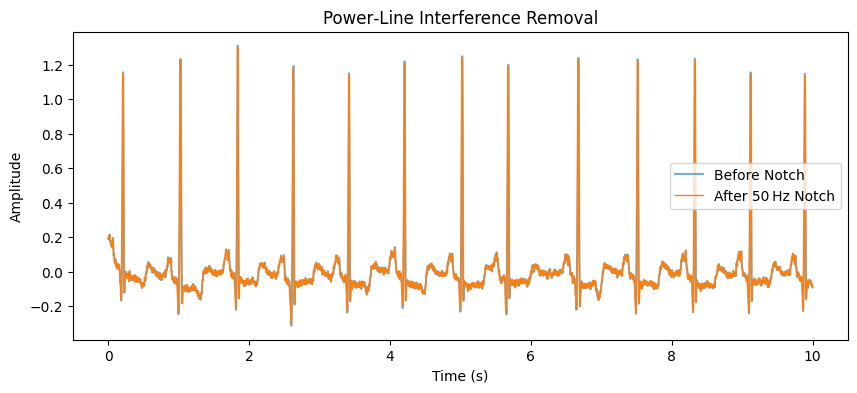

In [9]:
# Design notch filter
notch_freq = 50  # Hz
quality_factor = 30
b_notch, a_notch = iirnotch(notch_freq, quality_factor, fs)
# Apply notch filter
signal_notched = filtfilt(b_notch, a_notch, signal_baseline_removed)

# Plot before vs after
plt.figure(figsize=(10,4))
plt.plot(time[:n_plot], signal_baseline_removed[:n_plot], label='Before Notch', alpha=0.6)
plt.plot(time[:n_plot], signal_notched[:n_plot], label='After 50 Hz Notch', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Power‑Line Interference Removal')
plt.legend()
plt.show()

- **Observation:** The 50 Hz notch filter effectively suppresses periodic noise caused by electrical power sources. The filtered signal shows a reduction in high-frequency oscillations that were not part of the true ECG morphology.


### 3. Noise Reduction and Smoothing (Low-pass Filter)

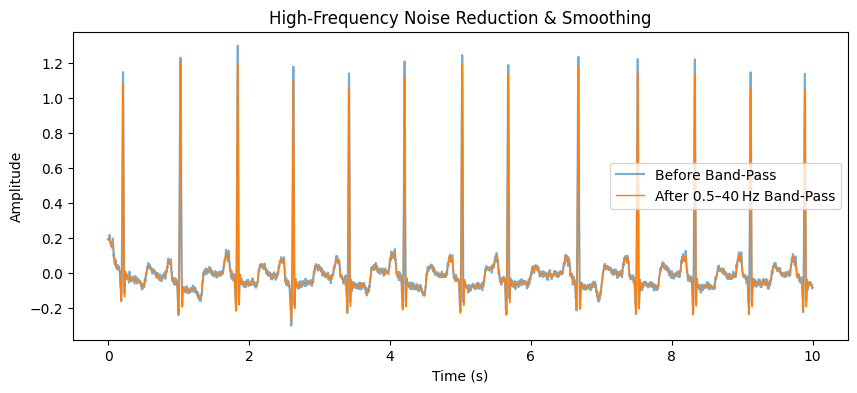

In [10]:
# Design low-pass filter (e.g., cutoff at 40 Hz)
lowcut = 40  # Hz
b_lp, a_lp = butter(N=4, Wn=lowcut/(fs/2), btype='low')
# Apply low-pass filter
signal_smoothed = filtfilt(b_lp, a_lp, signal_notched)
# Plot before vs after
plt.figure(figsize=(10,4))
plt.plot(time[:n_plot], signal_notched[:n_plot], label='Before Band‑Pass', alpha=0.6)
plt.plot(time[:n_plot], signal_smoothed[:n_plot], label='After 0.5–40 Hz Band‑Pass', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('High‑Frequency Noise Reduction & Smoothing')
plt.legend()
plt.show()

- **Observation:** The low-pass filter smooths out remaining high-frequency noise, resulting in a cleaner ECG trace. The main features of the ECG (such as QRS complexes) are preserved, while random noise is reduced, improving the signal-to-noise ratio.


- **Summary:** Each preprocessing step incrementally improves the quality of the ECG signal. Baseline wander and powerline interference are removed without distorting the main ECG features, and the final smoothing step enhances the clarity of the waveform, making it more suitable for further analysis like peak detection or classification.

In [11]:
# Save the smoothed signal and sampling frequency
np.save('../data/signal_smoothed.npy', signal_smoothed)
np.save('../data/fs.npy', fs)